# STORM

[STORM](https://arxiv.org/abs/2402.14207) is a research assistant designed by Shao, et. al that extends the idea of "outline-driven RAG" for richer article generation.

STORM is designed to generate Wikipedia-style ariticles on a user-provided topic. It applies two main insights to produce more organized and comprehensive articles:

1. Creating an outline (planning) by querying similar topics helps improve coverage.
2. Multi-perspective, grounded (in search) conversation simulation helps increase the reference count and information density. 

STORM has a few main stages:

1. Generate initial outline + Survey related subjects
2. Identify distinct perspectives
3. "Interview subject matter experts" (role-playing LLMs)
4. Refine outline (using references)
5. Write sections, then write article


The expert interviews stage ocurrs between the role-playing article writer and a research expert. The "expert" is able to query external knowledge and respond to pointed questions, saving cited sources to a vectorstore so that the later refinement stages can synthesize the full article.

There are a couple hyperparameters you can set to restrict the (potentially) infinite research breadth:

N: Number of perspectives to survey / use (Steps 2->3)
M: Max number of conversation turns in step (Step 3)


## Prerequisites

In [30]:
%pip install -U langchain_community langchain_openai langgraph wikipedia scikit-learn langchain_fireworks pygraphviz --quiet


Note: you may need to restart the kernel to use updated packages.


In [36]:
import os
from dotenv import load_dotenv
load_dotenv()

True

#### Select LLMs

We will have a faster LLM do most of the work, but a slower, long-context model to distill the conversations and write the final report.

In [38]:
from langchain_openai import AzureChatOpenAI

FAST_DEPLOYMENT_NAME="gpt-35-turbo"
FAST_MODEL_NAME = "gpt-35-turbo"

LONG_CONTEXT_DEPLOYMENT_NAME="gpt-4"
LONG_CONTEXT_MODEL_NAME = "gpt-4"

API_VERSION="2024-02-15-preview"

fast_llm = AzureChatOpenAI(
    azure_deployment=FAST_DEPLOYMENT_NAME, 
    model_name=FAST_MODEL_NAME, 
    openai_api_version=API_VERSION,
    temperature=0)

long_context_llm = AzureChatOpenAI(
    azure_deployment=LONG_CONTEXT_DEPLOYMENT_NAME, 
    model_name=LONG_CONTEXT_MODEL_NAME, 
    openai_api_version=API_VERSION,
    temperature=0)

## Generate Initial Outline

For many topics, your LLM may have an initial idea of the important and related topics. We can generate an initial
outline to be refined after our research. Below, we will use our "fast" llm to generate the outline.

In [39]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate

direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a Wikipedia writer. Write an outline for a Wikipedia page about a user-provided topic. Be comprehensive and specific.",
        ),
        ("user", "{topic}"),
    ]
)


class Subsection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    description: str = Field(..., title="Content of the subsection")

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.description}".strip()


class Section(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    description: str = Field(..., title="Content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            f"### {subsection.subsection_title}\n\n{subsection.description}"
            for subsection in self.subsections or []
        )
        return f"## {self.section_title}\n\n{self.description}\n\n{subsections}".strip()


class Outline(BaseModel):
    page_title: str = Field(..., title="Title of the Wikipedia page")
    sections: List[Section] = Field(
        default_factory=list,
        title="Titles and descriptions for each section of the Wikipedia page.",
    )

    @property
    def as_str(self) -> str:
        sections = "\n\n".join(section.as_str for section in self.sections)
        return f"# {self.page_title}\n\n{sections}".strip()


generate_outline_direct = direct_gen_outline_prompt | fast_llm.with_structured_output(
    Outline
)

In [40]:
example_topic = "Impact of million-plus token context window language models on RAG"

initial_outline = generate_outline_direct.invoke({"topic": example_topic})

print(initial_outline.as_str)

# Impact of million-plus token context window language models on RAG

## Introduction

Overview of million-plus token context window language models and their impact on the RAG (Retrieval-Augmented Generation) framework.

## RAG Framework

Explanation of the RAG framework, its components, and its use in natural language processing tasks.

## Million-Plus Token Context Window Language Models

Detailed description of million-plus token context window language models, including their architecture, training data, and applications in natural language processing.

## Impact on RAG

Discussion of the impact of million-plus token context window language models on the RAG framework, including improvements in retrieval, generation, and overall performance.


## Expand Topics

While language models do store some Wikipedia-like knowledge in their parameters, you will get better results by incorporating relevant and recent information using a search engine.

We will start our search by generating a list of related topics, sourced from Wikipedia.

In [41]:
gen_related_topics_prompt = ChatPromptTemplate.from_template(
    """I'm writing a Wikipedia page for a topic mentioned below. Please identify and recommend some Wikipedia pages on closely related subjects. I'm looking for examples that provide insights into interesting aspects commonly associated with this topic, or examples that help me understand the typical content and structure included in Wikipedia pages for similar topics.

Please list the as many subjects and urls as you can.

Topic of interest: {topic}
"""
)


class RelatedSubjects(BaseModel):
    topics: List[str] = Field(
        description="Comprehensive list of related subjects as background research.",
    )


expand_chain = gen_related_topics_prompt | fast_llm.with_structured_output(
    RelatedSubjects
)

In [42]:
related_subjects = await expand_chain.ainvoke({"topic": example_topic})
related_subjects

RelatedSubjects(topics=['Impact of million-plus token context window language models', 'RAG'])

## Generate Perspectives

From these related subjects, we can select representative Wikipedia editors as "subject matter experts" with distinct
backgrounds and affiliations. These will help distribute the search process to encourage a more well-rounded final report.

In [43]:
class Editor(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the editor.",
    )
    name: str = Field(
        description="Name of the editor.",
    )
    role: str = Field(
        description="Role of the editor in the context of the topic.",
    )
    description: str = Field(
        description="Description of the editor's focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


class Perspectives(BaseModel):
    editors: List[Editor] = Field(
        description="Comprehensive list of editors with their roles and affiliations.",
        # Add a pydantic validation/restriction to be at most M editors
    )


gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You need to select a diverse (and distinct) group of Wikipedia editors who will work together to create a comprehensive article on the topic. Each of them represents a different perspective, role, or affiliation related to this topic.\
    You can use other Wikipedia pages of related topics for inspiration. For each editor, add a description of what they will focus on.

    Wiki page outlines of related topics for inspiration:
    {examples}""",
        ),
        ("user", "Topic of interest: {topic}"),
    ]
)

gen_perspectives_chain = gen_perspectives_prompt | AzureChatOpenAI(
    azure_deployment=FAST_DEPLOYMENT_NAME, 
    model_name=FAST_MODEL_NAME, 
    openai_api_version=API_VERSION,
    temperature=0).with_structured_output(Perspectives)

In [44]:
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.runnables import RunnableLambda, chain as as_runnable

wikipedia_retriever = WikipediaRetriever(load_all_available_meta=True, top_k_results=1)


def format_doc(doc, max_length=1000):
    related = "- ".join(doc.metadata["categories"])
    return f"### {doc.metadata['title']}\n\nSummary: {doc.page_content}\n\nRelated\n{related}"[
        :max_length
    ]


def format_docs(docs):
    return "\n\n".join(format_doc(doc) for doc in docs)


@as_runnable
async def survey_subjects(topic: str):
    related_subjects = await expand_chain.ainvoke({"topic": topic})
    retrieved_docs = await wikipedia_retriever.abatch(
        related_subjects.topics, return_exceptions=True
    )
    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)
    formatted = format_docs(all_docs)
    return await gen_perspectives_chain.ainvoke({"examples": formatted, "topic": topic})

In [45]:
perspectives = await survey_subjects.ainvoke(example_topic)

/home/ythuang/venvs/openai/lib/python3.10/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /home/ythuang/venvs/openai/lib/python3.10/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [46]:
perspectives.dict()

{'editors': [{'affiliation': 'Research Institution',
   'name': 'Dr. NLP Researcher',
   'role': 'Researcher',
   'description': 'Dr. NLP Researcher specializes in natural language processing and will focus on the impact of million-plus token context window language models on RAG from a research perspective.'},
  {'affiliation': 'Tech Company',
   'name': 'AI Engineer',
   'role': 'Engineer',
   'description': 'AI Engineer works for a tech company and will provide insights into the technical aspects of million-plus token context window language models and their impact on RAG.'},
  {'affiliation': 'Academic Institution',
   'name': 'Prof. Linguist',
   'role': 'Linguist',
   'description': 'Prof. Linguist is a linguistics expert and will contribute insights into the linguistic implications of million-plus token context window language models on RAG.'},
  {'affiliation': 'Media Company',
   'name': 'Tech Journalist',
   'role': 'Journalist',
   'description': 'Tech Journalist will focus 

## Expert Dialog

Now the true fun begins, each wikipedia writer is primed to role-play using the perspectives presented above. It will ask a series of questions of a second "domain expert" with access to a search engine. This generate content to generate a refined outline as well as an updated index of reference documents.


### Interview State

The conversation is cyclic, so we will construct it within its own graph. The State will contain messages, the reference docs, and the editor (with its own "persona") to make it easy to parallelize these conversations.

In [47]:
from langgraph.graph import StateGraph, END
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated, Sequence


def add_messages(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left + right


def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references


def update_editor(editor, new_editor):
    # Can only set at the outset
    if not editor:
        return new_editor
    return editor


class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]

#### Dialog Roles

The graph will have two participants: the wikipedia editor (`generate_question`), who asks questions based on its assigned role, and a domain expert (`gen_answer_chain), who uses a search engine to answer the questions as accurately as possible.

In [48]:
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage


gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an experienced Wikipedia writer and want to edit a specific page. \
Besides your identity as a Wikipedia writer, you have a specific focus when researching the topic. \
Now, you are chatting with an expert to get information. Ask good questions to get more useful information.

When you have no more questions to ask, say "Thank you so much for your help!" to end the conversation.\
Please only ask one question at a time and don't ask what you have asked before.\
Your questions should be related to the topic you want to write.
Be comprehensive and curious, gaining as much unique insight from the expert as possible.\

Stay true to your specific perspective:

{persona}""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)


def tag_with_name(ai_message: AIMessage, name: str):
    ai_message.name = name
    return ai_message


def swap_roles(state: InterviewState, name: str):
    converted = []
    for message in state["messages"]:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.dict(exclude={"type"}))
        converted.append(message)
    return {"messages": converted}


@as_runnable
async def generate_question(state: InterviewState):
    editor = state["editor"]
    gn_chain = (
        RunnableLambda(swap_roles).bind(name=editor.name)
        | gen_qn_prompt.partial(persona=editor.persona)
        | fast_llm
        | RunnableLambda(tag_with_name).bind(name=editor.name)
    )
    result = await gn_chain.ainvoke(state)
    return {"messages": [result]}

In [49]:
messages = [
    HumanMessage(f"So you said you were writing an article on {example_topic}?")
]
question = await generate_question.ainvoke(
    {
        "editor": perspectives.editors[0],
        "messages": messages,
    }
)

question["messages"][0].content

"Yes, that's correct. I'm interested in understanding the impact of using million-plus token context window language models on the Retrieval-Augmented Generation (RAG) model. Can you provide insights into how these large context window language models affect the performance and capabilities of RAG?"

#### Answer questions

The `gen_answer_chain` first generates queries (query expansion) to answer the editor's question, then responds with citations.

In [50]:
class Queries(BaseModel):
    queries: List[str] = Field(
        description="Comprehensive list of search engine queries to answer the user's questions.",
    )


gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful research assistant. Query the search engine to answer the user's questions.",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)
gen_queries_chain = gen_queries_prompt | AzureChatOpenAI(
    azure_deployment=FAST_DEPLOYMENT_NAME, 
    model_name=FAST_MODEL_NAME, 
    openai_api_version=API_VERSION,
    temperature=0).with_structured_output(Queries, include_raw=True)

In [51]:
queries = await gen_queries_chain.ainvoke(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
queries["parsed"].queries

['impact of million-plus token context window language models on Retrieval-Augmented Generation (RAG) model',
 'performance of RAG with large context window language models',
 'capabilities of RAG with million-plus token context window language models']

In [52]:
class AnswerWithCitations(BaseModel):
    answer: str = Field(
        description="Comprehensive answer to the user's question with citations.",
    )
    cited_urls: List[str] = Field(
        description="List of urls cited in the answer.",
    )

    @property
    def as_str(self) -> str:
        return f"{self.answer}\n\nCitations:\n\n" + "\n".join(
            f"[{i+1}]: {url}" for i, url in enumerate(self.cited_urls)
        )


gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert who can use information effectively. You are chatting with a Wikipedia writer who wants\
 to write a Wikipedia page on the topic you know. You have gathered the related information and will now use the information to form a response.

Make your response as informative as possible and make sure every sentence is supported by the gathered information.
Each response must be backed up by a citation from a reliable source, formatted as a footnote, reproducing the URLS after your response.""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

gen_answer_chain = gen_answer_prompt | fast_llm.with_structured_output(
    AnswerWithCitations, include_raw=True
).with_config(run_name="GenerateAnswer")

In [53]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain_core.tools import tool

search_engine = DuckDuckGoSearchAPIWrapper()
# Tavily is typically a better search engine, but your free queries are limited
# search_engine = TavilySearchResults(max_results=4)


@tool
async def search_engine(query: str):
    """Search engine to the internet."""
    results = DuckDuckGoSearchAPIWrapper()._ddgs_text(query)
    return [{"content": r["body"], "url": r["href"]} for r in results]

In [54]:
from langchain_core.runnables import RunnableConfig
import json


async def gen_answer(
    state: InterviewState,
    config: RunnableConfig | None = None,
    name: str = "Subject Matter Expert",
    max_str_len: int = 15000,
):
    swapped_state = swap_roles(state, name)  # Convert all other AI messages
    queries = await gen_queries_chain.ainvoke(swapped_state)
    query_results = await search_engine.abatch(
        queries["parsed"].queries, config, return_exceptions=True
    )
    successful_results = [
        res for res in query_results if not isinstance(res, Exception)
    ]
    all_query_results = {
        res["url"]: res["content"] for results in successful_results for res in results
    }
    # We could be more precise about handling max token length if we wanted to here
    dumped = json.dumps(all_query_results)[:max_str_len]
    ai_message: AIMessage = queries["raw"]
    tool_call = queries["raw"].additional_kwargs["tool_calls"][0]
    tool_id = tool_call["id"]
    tool_message = ToolMessage(tool_call_id=tool_id, content=dumped)
    swapped_state["messages"].extend([ai_message, tool_message])
    # Only update the shared state with the final answer to avoid
    # polluting the dialogue history with intermediate messages
    generated = await gen_answer_chain.ainvoke(swapped_state)
    cited_urls = set(generated["parsed"].cited_urls)
    # Save the retrieved information to a the shared state for future reference
    cited_references = {k: v for k, v in all_query_results.items() if k in cited_urls}
    formatted_message = AIMessage(name=name, content=generated["parsed"].as_str)
    return {"messages": [formatted_message], "references": cited_references}

In [55]:
example_answer = await gen_answer(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
example_answer["messages"][-1].content

"The impact of using million-plus token context window language models on the Retrieval-Augmented Generation (RAG) model has sparked discussions in the AI community. Some predict a negative impact on RAG due to the introduction of Gemini 1.5, which boasts a 1 million token context window. However, RAG has been shown to address the limitations of language models (LLMs) with smaller context windows, as it leverages an authoritative knowledge base beyond the original training data sources to refine its responses during the generation process. Studies have revealed that RAG, when combined with large language models (LLMs) such as GPT-4, delivers superior performance at a fraction of the cost, making it a more efficient choice for specializing LLMs' responses. Additionally, RAG has been found to outperform non-retrieval LLM baselines in terms of average score on long context tasks, including question answering, query-based summarization, and in-context few-shot learning tasks. The future of

#### Construct the Interview Graph


Now that we've defined the editor and domain expert, we can compose them in a graph.

In [56]:
max_num_turns = 5


def route_messages(state: InterviewState, name: str = "Subject Matter Expert"):
    messages = state["messages"]
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    if num_responses >= max_num_turns:
        return END
    last_question = messages[-2]
    if last_question.content.endswith("Thank you so much for your help!"):
        return END
    return "ask_question"


builder = StateGraph(InterviewState)

builder.add_node("ask_question", generate_question)
builder.add_node("answer_question", gen_answer)
builder.add_conditional_edges("answer_question", route_messages)
builder.add_edge("ask_question", "answer_question")

builder.set_entry_point("ask_question")
interview_graph = builder.compile().with_config(run_name="Conduct Interviews")

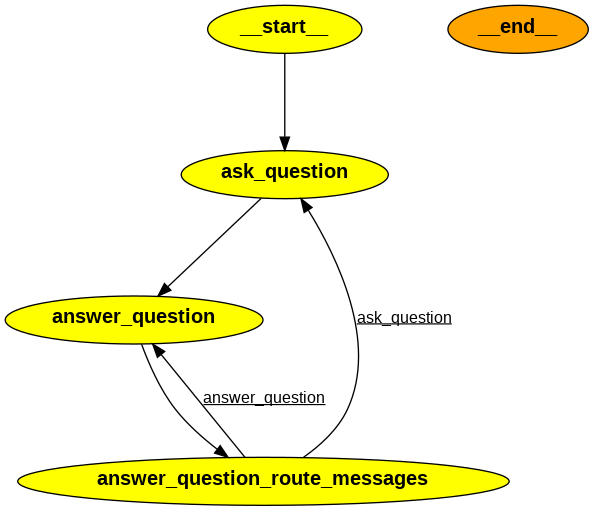

In [58]:
from IPython.display import Image

# Feel free to comment out if you have
# not installed pygraphviz
Image(interview_graph.get_graph().draw_png())

In [59]:
final_step = None

initial_state = {
    "editor": perspectives.editors[0],
    "messages": [
        AIMessage(
            content=f"So you said you were writing an article on {example_topic}?",
            name="Subject Matter Expert",
        )
    ],
}
async for step in interview_graph.astream(initial_state):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name]["messages"])[:300])
    if END in step:
        final_step = step

ask_question
--  [AIMessage(content="Yes, that's correct. I'm interested in understanding the impact of million-plus token context window language models on the RAG (Retrieval-Augmented Generation) framework. Can you provide insights into how these large context window language models affect the performance and capa
answer_question
--  [AIMessage(content='The introduction of large context window language models, such as Gemini 1.5 with a 1 million token context window, has sparked discussions in the AI community regarding its impact on the Retrieval-Augmented Generation (RAG) framework. These large context window models have the c
ask_question
--  [AIMessage(content="Thank you for sharing this insightful information. I'm particularly interested in understanding the practical implications of using these large context window language models, such as Gemini 1.5 and LongRoPE, within the RAG framework. Can you provide more details on the specific 
answer_question
--  [AIMessage(content='The

In [60]:
final_state = next(iter(final_step.values()))

## Refine Outline

At this point in STORM, we've conducted a large amount of research from different perspectives. It's time to refine the original outline based on these investigations. Below, create a chain using the LLM with a long context window to update the original outline.

In [61]:
refine_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a Wikipedia writer. You have gathered information from experts and search engines. Now, you are refining the outline of the Wikipedia page. \
You need to make sure that the outline is comprehensive and specific. \
Topic you are writing about: {topic} 

Old outline:

{old_outline}""",
        ),
        (
            "user",
            "Refine the outline based on your conversations with subject-matter experts:\n\nConversations:\n\n{conversations}\n\nWrite the refined Wikipedia outline:",
        ),
    ]
)

# Using turbo preview since the context can get quite long
refine_outline_chain = refine_outline_prompt | long_context_llm.with_structured_output(
    Outline
)

In [62]:
refined_outline = refine_outline_chain.invoke(
    {
        "topic": example_topic,
        "old_outline": initial_outline.as_str,
        "conversations": "\n\n".join(
            f"### {m.name}\n\n{m.content}" for m in final_state["messages"]
        ),
    }
)

In [63]:
print(refined_outline.as_str)

# Impact of Million-Plus Token Context Window Language Models on RAG

## Introduction

Overview of the impact of million-plus token context window language models on the RAG (Retrieval-Augmented Generation) framework, including a brief introduction to models like Gemini 1.5 and LongRoPE.

## Background

Explanation of the RAG framework and million-plus token context window language models, their significance in natural language processing, and the evolution of context window sizes.

### RAG Framework

Detailed explanation of the RAG framework, its components, and its use in natural language processing tasks.

### Million-Plus Token Context Window Language Models

In-depth description of million-plus token context window language models, including their architecture, training data, and applications in natural language processing.

## Impact on RAG

Comprehensive discussion of the impact of million-plus token context window language models on the RAG framework, including improvements in 

## Generate Article

Now it's time to generate the full article. We will first divide-and-conquer, so that each section can be tackled by an individual llm. Then we will prompt the long-form LLM to refine the finished article (since each section may use an inconsistent voice).

#### Create Retriever

The research process uncovers a large number of reference documents that we may want to query during the final article-writing process.

First, create the retriever:

In [65]:
from langchain_core.documents import Document

from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import AzureOpenAIEmbeddings

EMBEDDINGS_DEPLOYMENT_NAME = "text-embedding-ada-002"
EMBEDDINGS_API_VERSION = "2024-02-15-preview"

embeddings = AzureOpenAIEmbeddings(
        azure_deployment=EMBEDDINGS_DEPLOYMENT_NAME,
        openai_api_version=EMBEDDINGS_API_VERSION)
    
reference_docs = [
    Document(page_content=v, metadata={"source": k})
    for k, v in final_state["references"].items()
]
# This really doesn't need to be a vectorstore for this size of data.
# It could just be a numpy matrix. Or you could store documents
# across requests if you want.
vectorstore = SKLearnVectorStore.from_documents(
    reference_docs,
    embedding=embeddings,
)
retriever = vectorstore.as_retriever(k=10)

In [66]:
retriever.invoke("What's a long context LLM anyway?")

[Document(page_content='Source: "Lost in the Middle: How Language Models Use Long Contexts", F. Liu et al. 2023. \u200d "LLM accuracy is highest when relevant information occurs at the very start or end of a long ...', metadata={'id': '1a15881e-aa6e-4ccb-992f-ad29588e283d', 'source': 'https://medium.com/@jm_51428/long-context-window-models-vs-rag-a73c35a763f2'}),
 Document(page_content='By the way, the context limits differ among models: two Claude models offer a 100K token context window, which works out to about 75,000 words, which is much higher than most other LLMs. The ...', metadata={'id': '9982d445-dcec-45f1-ac6d-58c992c4166c', 'source': 'https://www.infoworld.com/article/3712227/what-is-rag-more-accurate-and-reliable-llms.html'}),
 Document(page_content='Large context window is a desirable feature in large language models (LLMs). However, due to high fine-tuning costs, scarcity of long texts, and catastrophic values introduced by new token positions, current extended context wi

#### Generate Sections

Now you can generate the sections using the indexed docs.

In [67]:
class SubSection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    content: str = Field(
        ...,
        title="Full content of the subsection. Include [#] citations to the cited sources where relevant.",
    )

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.content}".strip()


class WikiSection(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    content: str = Field(..., title="Full content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )
    citations: List[str] = Field(default_factory=list)

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            subsection.as_str for subsection in self.subsections or []
        )
        citations = "\n".join([f" [{i}] {cit}" for i, cit in enumerate(self.citations)])
        return (
            f"## {self.section_title}\n\n{self.content}\n\n{subsections}".strip()
            + f"\n\n{citations}".strip()
        )


section_writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Wikipedia writer. Complete your assigned WikiSection from the following outline:\n\n"
            "{outline}\n\nCite your sources, using the following references:\n\n<Documents>\n{docs}\n<Documents>",
        ),
        ("user", "Write the full WikiSection for the {section} section."),
    ]
)


async def retrieve(inputs: dict):
    docs = await retriever.ainvoke(inputs["topic"] + ": " + inputs["section"])
    formatted = "\n".join(
        [
            f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )
    return {"docs": formatted, **inputs}


section_writer = (
    retrieve
    | section_writer_prompt
    | long_context_llm.with_structured_output(WikiSection)
)

In [68]:
section = await section_writer.ainvoke(
    {
        "outline": refined_outline.as_str,
        "section": refined_outline.sections[1].section_title,
        "topic": example_topic,
    }
)
print(section.as_str)

## Background

The advent of million-plus token context window language models has marked a significant milestone in the field of natural language processing (NLP). These models have the capacity to process and understand vast amounts of text in a single instance, which has profound implications for various NLP tasks. The Retrieval-Augmented Generation (RAG) framework is one such area that has been impacted by these advancements. The evolution of context window sizes from hundreds to thousands and now to over a million tokens has enabled models to capture more nuanced and complex relationships within the text, leading to more coherent and contextually relevant outputs.

### RAG Framework

The RAG framework is a novel approach that combines the strengths of pre-trained language models with neural information retrieval to enhance the generation of text. It operates by first converting input text into vector embeddings, which are then stored in a database. During the generation phase, the

#### Generate final article

Now we can rewrite the draft to appropriately group all the citations and maintain a consistent voice.

In [71]:
from langchain_core.output_parsers import StrOutputParser

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Wikipedia author. Write the complete wiki article on {topic} using the following section drafts:\n\n"
            "{draft}\n\nStrictly follow Wikipedia format guidelines.",
        ),
        (
            "user",
            'Write the complete Wiki article using markdown format. Organize citations using footnotes like "[1]",'
            ' avoiding duplicates in the footer. Include URLs in the footer.',
        ),
    ]
)

writer = writer_prompt | long_context_llm | StrOutputParser()

In [73]:
for tok in writer.stream({"topic": example_topic, "draft": section.as_str}):
    print(tok, end="")

# Impact of Million-Plus Token Context Window Language Models on RAG

The impact of million-plus token context window language models on Retrieval-Augmented Generation (RAG) has been a subject of significant interest within the field of natural language processing (NLP). These advanced models have expanded the capabilities of NLP systems, allowing them to process and comprehend large volumes of text, which has had a transformative effect on the RAG framework and related applications.

## Background

The development of language models with the ability to handle context windows of over a million tokens has been a notable achievement in NLP. These models can process extensive text in a single instance, capturing intricate and complex relationships within the data. This capability has led to improvements in the coherence and relevance of generated text, particularly in systems that rely on understanding broad contexts, such as the RAG framework[1].

## RAG Framework

The RAG framework is a

## Final Flow

Now it's time to string everything together. We will have 6 main stages in sequence:
.
1. Generate the initial outline + perspectives
2. Batch converse with each perspective to expand the content for the article
3. Refine the outline based on the conversations
4. Index the reference docs from the conversations
5. Write the individual sections of the article
6. Write the final wiki

The state tracks the outputs of each stage.

In [74]:
class ResearchState(TypedDict):
    topic: str
    outline: Outline
    editors: List[Editor]
    interview_results: List[InterviewState]
    # The final sections output
    sections: List[WikiSection]
    article: str

In [75]:
import asyncio


async def initialize_research(state: ResearchState):
    topic = state["topic"]
    coros = (
        generate_outline_direct.ainvoke({"topic": topic}),
        survey_subjects.ainvoke(topic),
    )
    results = await asyncio.gather(*coros)
    return {
        **state,
        "outline": results[0],
        "editors": results[1].editors,
    }


async def conduct_interviews(state: ResearchState):
    topic = state["topic"]
    initial_states = [
        {
            "editor": editor,
            "messages": [
                AIMessage(
                    content=f"So you said you were writing an article on {topic}?",
                    name="Subject Matter Expert",
                )
            ],
        }
        for editor in state["editors"]
    ]
    # We call in to the sub-graph here to parallelize the interviews
    interview_results = await interview_graph.abatch(initial_states)

    return {
        **state,
        "interview_results": interview_results,
    }


def format_conversation(interview_state):
    messages = interview_state["messages"]
    convo = "\n".join(f"{m.name}: {m.content}" for m in messages)
    return f'Conversation with {interview_state["editor"].name}\n\n' + convo


async def refine_outline(state: ResearchState):
    convos = "\n\n".join(
        [
            format_conversation(interview_state)
            for interview_state in state["interview_results"]
        ]
    )

    updated_outline = await refine_outline_chain.ainvoke(
        {
            "topic": state["topic"],
            "old_outline": state["outline"].as_str,
            "conversations": convos,
        }
    )
    return {**state, "outline": updated_outline}


async def index_references(state: ResearchState):
    all_docs = []
    for interview_state in state["interview_results"]:
        reference_docs = [
            Document(page_content=v, metadata={"source": k})
            for k, v in interview_state["references"].items()
        ]
        all_docs.extend(reference_docs)
    await vectorstore.aadd_documents(all_docs)
    return state


async def write_sections(state: ResearchState):
    outline = state["outline"]
    sections = await section_writer.abatch(
        [
            {
                "outline": refined_outline.as_str,
                "section": section.section_title,
                "topic": state["topic"],
            }
            for section in outline.sections
        ]
    )
    return {
        **state,
        "sections": sections,
    }


async def write_article(state: ResearchState):
    topic = state["topic"]
    sections = state["sections"]
    draft = "\n\n".join([section.as_str for section in sections])
    article = await writer.ainvoke({"topic": topic, "draft": draft})
    return {
        **state,
        "article": article,
    }

#### Create the graph

In [76]:
builder_of_storm = StateGraph(ResearchState)

nodes = [
    ("init_research", initialize_research),
    ("conduct_interviews", conduct_interviews),
    ("refine_outline", refine_outline),
    ("index_references", index_references),
    ("write_sections", write_sections),
    ("write_article", write_article),
]
for i in range(len(nodes)):
    name, node = nodes[i]
    builder_of_storm.add_node(name, node)
    if i > 0:
        builder_of_storm.add_edge(nodes[i - 1][0], name)

builder_of_storm.set_entry_point(nodes[0][0])
builder_of_storm.set_finish_point(nodes[-1][0])
storm = builder_of_storm.compile()

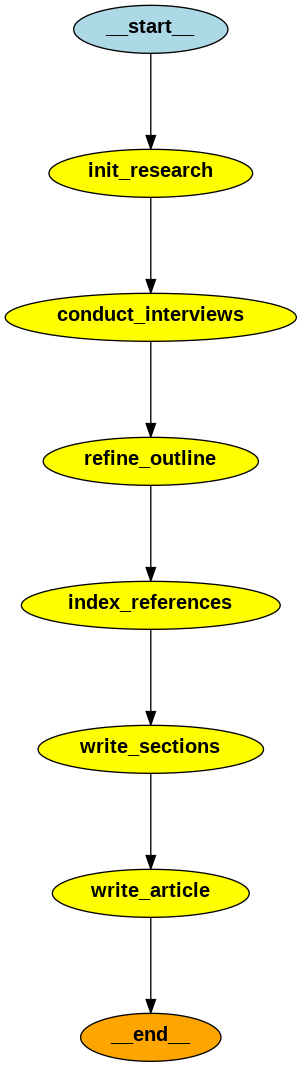

In [77]:
Image(storm.get_graph().draw_png())

In [3]:
async for step in storm.astream(
    {
        "topic": "Groq, NVIDIA, Llamma.cpp and the future of LLM Inference",
    }
):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name])[:300])
    if END in step:
        results = step

NameError: name 'storm' is not defined

In [2]:
article = results[END]["article"]

NameError: name 'results' is not defined

## Render the Wiki

Now we can render the final wiki page!

In [1]:
from IPython.display import Markdown

# We will down-header the sections to create less confusion in this notebook
Markdown(article.replace("\n#", "\n##"))

NameError: name 'article' is not defined